In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_7096/3559585180.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with varying widths and occluding bars

In [2]:
n_gauss     = 1000 # Total 2000 images
img_size    = 91

x    = np.linspace(start=-4, stop=4, num=img_size)
X, Y = np.meshgrid(x, x)

# Vary the weight smoothly
widths = np.linspace(start=2, stop=20, num=n_gauss)

# Initialize tensors containing images
images = torch.zeros(n_gauss, 1, img_size, img_size)

for i in range(n_gauss):
    
    # Create the gaussian with random centers
    # Ro = random offset
    # `i % 2`: Even image belong to label 0
    ro = 1.5 * np.random.randn(2)
    G  = np.exp(-((X - ro[0]) ** 2 + (Y - ro[1]) ** 2) / widths[i])
    
    # And add noise
    G += np.random.randn(img_size, img_size) / 5
    
    # Add a random bar randomly
    i1 = np.random.choice(np.arange(2, 28))
    i2 = np.random.choice(np.arange(2, 6))
    
    if np.random.randn() > 0:
        G[i1:i1 + i2, :] = 1
    else:
        G[:, i1:i1 + i2] = 1
    
    # Add to the tensor
    # `.view`: Convert from numpy matrix to PTorch Tensor
    images[i, :, :, :] = torch.tensor(G).view(1, img_size, img_size)

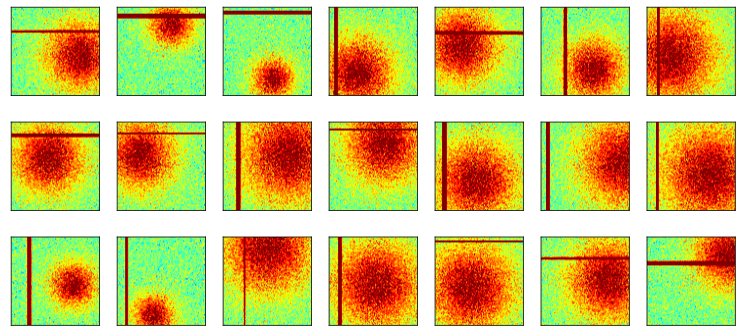

In [5]:
# Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):
    which_pic = np.random.randint(n_gauss)
    G         = np.squeeze(images[which_pic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Create the DL model

In [10]:
def make_the_net():
    """
    CNN_GAUSS_AUTOENCODER
    """
    class gauss_net(nn.Module):
        def __init__(self):
            super().__init__()
            
            # Encoding layer
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                
                nn.Conv2d(6, 4, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2)
            )
            
            # Decoding layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4, 6, 3, 2),
                nn.ReLU(),
                nn.ConvTranspose2d(6, 1, 3, 2)
            )
        
        def forward(self, x):
            return self.dec(self.enc(x))
        
    
    # Create the model instance
    net = gauss_net()
    
    # Loss Function
    loss_func = nn.MSELoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
    
    return net, loss_func, optimizer


torch.Size([10, 1, 91, 91])


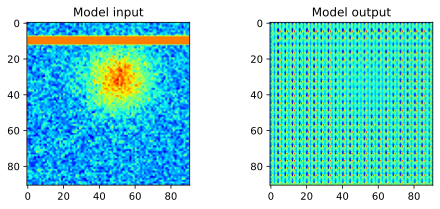

In [11]:
# Test the model with one batch
net, loss_func, optimizer = make_the_net()

y_hat = net(images[:10, :, :, :])

# Check size of output
print('')
print(y_hat.shape)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].imshow(torch.squeeze(images[0, 0, :, :]).detach(), cmap='jet')
ax[1].imshow(torch.squeeze(y_hat [0, 0, :, :]).detach(), cmap='jet')
ax[0].set_title('Model input')
ax[1].set_title('Model output')

plt.show()

In [12]:
# count the total number of parameters in the model
summary(model=net, input_data=(1, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

# Create a function that trains the model

In [18]:
def train_the_model():
    """
    CNN_GAUSS_AUTOENCODER
    """
    
    num_epochs = 500

    # Create a new model
    net, loss_func, optimizer = make_the_net()

    # Initialize
    losses = torch.zeros(num_epochs)
    
    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Pick a set of images at random
        pics_2_use = np.random.choice(n_gauss, size=32, replace=False)
        X          = images[pics_2_use, :, :, :]
        
        # Forward pass and loss
        y_hat           = net(X)
        loss            = loss_func(y_hat, X)
        losses[epoch_i] = loss.item()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # End epochs
    return losses, net

# Run the model and show the results!

In [19]:
# Test the model on a bit of data
losses, net = train_the_model()

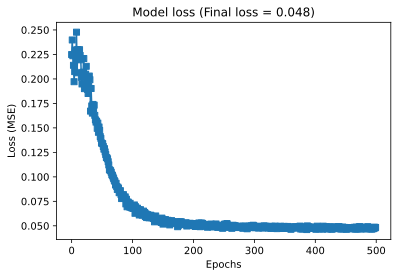

In [20]:
plt.plot(losses, 's-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Model loss (Final loss = {losses[-1]:.3f})')
plt.show()

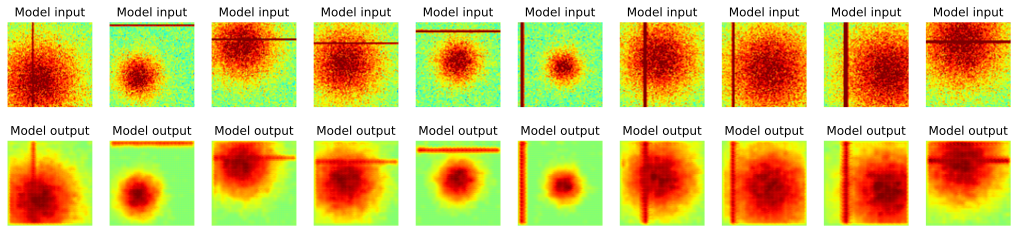

In [21]:
pics_2_use = np.random.choice(n_gauss, size=32, replace=False)
X          = images[pics_2_use, :, :, :]
y_hat      = net(X)

fig, axs = plt.subplots(2, 10, figsize=(18, 4))
for i in range(10):
    G = torch.squeeze(X    [i, 0, :, :]).detach()
    O = torch.squeeze(y_hat[i, 0, :, :]).detach()
    
    axs[0, i].imshow(G, vmin=-1, vmax=1, cmap='jet')
    axs[0, i].axis('off')
    axs[0, i].set_title('Model input')
    
    axs[1, i].imshow(O, vmin=-1, vmax=1, cmap='jet')
    axs[1, i].axis('off')
    axs[1, i].set_title('Model output')

plt.show()

# Additional explorations

In [ ]:
# 1) There are no test data here, so how do you know whether the model overfit the training set? Fortunately, you can
#    simply create as much new data as you want! That's one of the advantages of generating data ;)
#    Generate a new dataset to use as a test set. How does the MSE loss compare on the test set? Did we overfit here?
# 
# 2) The code here uses MaxPool. Are the results noticeably different if you use AvgPool instead?
# 
# 3) The final output doesn't have a nonlinearity (e.g., relu, sigmoid, tanh). Does it need one? Would that help? What
#    are some arguments for and against having a nonlinear activation function on the output of the decover? Try adding
#    one and see if it improves (via the final loss and visual inspection) the result.
# 
# 4) I mentioned in the lecture "What are autoencoders and what do they do?" (section "Autoencoders") that BCEloss can be
#    used when the data are between 0 and 1. Normalize the images so they are appropriately scaled, and then use BCEloss
#    instead of MSEloss (does anything else in the model architecture need to change?). Which loss function gives a 
#    better result?
# 